# Analyze the model performance

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import dill 
import pandas as pd 
import numpy as np 
import joblib
from descriptornames import *

In [66]:
with open('model.dill', 'rb') as fh: 
    model = dill.load(fh)

In [48]:
# -*- coding: utf-8 -*-
"""
Filename: /home/kevin/Dropbox (LSMO)/proj75_mofcolor/ml/code/utils.py
Path: /home/kevin/Dropbox (LSMO)/proj75_mofcolor/ml/code
Created Date: Monday, February 24th 2020, 4:42:56 pm
Author: Kevin Jablonka

Copyright (c) 2020 Kevin Jablonka
"""

import os
import collections
import pickle
import random
import numpy as np
import matplotlib.patches as mpatch
from webcolors import rgb_to_hex
import matplotlib.pyplot as plt
from comet_ml import Experiment
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras import backend as BK
import pandas as pd
import ruamel.yaml as yaml
from descriptornames import *
from numpy.random import seed
import joblib


def augment_data(
    df, augment_dict, r_col="r", g_col="g", b_col="b", name_col="color_cleaned"
):
    df_ = df.copy()

    new_rows = []
    for i, row in df.iterrows():
        color = row[name_col]
        r_ = row.copy()
        for rgb in augment_dict[color]:
            r_[r_col] = rgb[0]
            r_[g_col] = rgb[1]
            r_[b_col] = rgb[2]
            new_rows.append(r_)

    new_df = pd.concat([df, pd.DataFrame(new_rows)])
    return new_df


def augment_random(colorname, augment_dict):
    possible_colors = augment_dict[colorname]
    chosen_color = random.choice(possible_colors)
    return np.array(chosen_color)


def tf_augment_random():
    raise NotImplementedError


def read_pickle(file):
    with open(file, "rb") as fh:
        result = pickle.load(fh)
    return result


def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = (
        tf.abs(error) < 1
    )  # replace `tf` with `K` where `K = keras.backend`
    squared_loss = tf.square(error) / 2  # replace `tf` with `K`
    linear_loss = tf.abs(error) - 0.5  # replace `tf` with `K`
    return tf.where(is_small_error, squared_loss, linear_loss)


def get_timestamp_string():
    t = time.localtime()
    timestamp = time.strftime("%b-%d-%Y_%H%M", t)
    return timestamp


def mapping_to_target_range(x, target_min=0, target_max=1):
    """Linear activation function that constrains output to a range
    
    Arguments:
        x {tensor} -- input tensor
    
    Keyword Arguments:
        target_min {float} -- minimum output (default: {0})
        target_max {float} -- maximum output (default: {1})
    
    Returns:
        tensor -- constrained linear activation
    """
    x02 = x + 1  # x in range(0,2)
    scale = (target_max - target_min) / 2.0
    return x02 * scale + target_min


def mapping_to_target_range_sig(x, target_min=0, target_max=255):
    """Sigmoid activation function that constrains output to a range
    
    Arguments:
        x {tensor} -- input tensor
    
    Keyword Arguments:
        target_min {float} -- minimum output (default: {0})
        target_max {float} -- maximum output (default: {255})
    
    Returns:
        tensor -- constrained Sigmoid activation
    """
    x02 = BK.sigmoid(x) + 1  # x in range(0,2)
    scale = (target_max - target_min) / 2.0
    return x02 * scale + target_min


def plot_predictions(predictions, labels, names, sample=100, outname=None):
    """Plot figure that compares color of predictions versus acutal colors.
    
    Arguments:
        predictions {iterable} -- iterable of rgb colors
        labels {iterable} -- iterable of rgb colors
        names {iterable} -- iterable of strings
    
    Keyword Arguments:
        sample {int} -- how many samples to plot (default: {100})
        outname {string} -- path to which figure is saved (default: {None})
    """
    fig = plt.figure(figsize=[4.8, 16])
    ax = fig.add_axes([0, 0, 1, 1])

    predictions = predictions[:sample]
    names = names[:sample]
    labels = labels[:sample]

    predictions = [rgb_to_hex((int(c[0]), int(c[1]), int(c[2]))) for c in predictions]
    true = [rgb_to_hex((int(c[0]), int(c[1]), int(c[2]))) for c in labels]

    for i in range(len(predictions)):
        r1 = mpatch.Rectangle((0, i), 1, 1, color=predictions[i])
        r2 = mpatch.Rectangle((1, i), 1, 1, color=true[i])
        txt = ax.text(2, i + 0.5, "  " + names[i], va="center", fontsize=10)

        ax.add_patch(r1)
        ax.add_patch(r2)
        ax.axhline(i, color="k")

    ax.text(0.5, i + 1.5, "prediction", ha="center", va="center")
    ax.text(1.5, i + 1.5, "median RGB for label", ha="center", va="center")
    ax.set_xlim(0, 3)
    ax.set_ylim(0, i + 2)
    ax.axis("off")

    fig.tight_layout()

    if outname is not None:
        fig.savefig(outname, bbox_inches="tight")


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def parse_config(yml_file):
    with open(yml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return config


def make_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)


def select_features(selection: list):
    selected_features = []
    for feature in selection:
        selected_features.extend(descriptor_dict[feature])

    return selected_features

    

In [49]:
scaler = joblib.load("scaler.joblib")

In [50]:
df = pd.read_csv("../data/color_feat_merged.csv")

In [51]:
df.tail()

,Unnamed: 0,mc_CRY-chi-0-all,mc_CRY-chi-1-all,mc_CRY-chi-2-all,mc_CRY-chi-3-all,mc_CRY-Z-0-all,mc_CRY-Z-1-all,mc_CRY-Z-2-all,mc_CRY-Z-3-all,mc_CRY-I-0-all,...,sum-D_func-alpha-0-all,sum-D_func-alpha-1-all,sum-D_func-alpha-2-all,sum-D_func-alpha-3-all,color_cleaned,color_string,delta_t_seconds,r,g,b
6395,6395,5.108425,34.7784,20.158675,86.624362,4659.25,2482.00,17679.375,6179.75,1.0,...,0.0,-52.8,-37.333333,-95.2,wheat,wheat,18.112884,224.0,201.0,104.0
6396,6396,3.145975,29.3170,32.018275,79.484200,864.75,1114.75,1947.500,2588.00,1.0,...,0.0,650.1,0.000000,0.0,ruby red,ruby red,20.483727,197.5,9.0,22.5
6397,6397,3.610000,21.6600,28.462000,50.730000,841.00,3480.00,2436.000,4524.00,1.0,...,0.0,0.0,0.000000,0.0,black brown,black brown,32.576774,62.5,40.5,13.0
6398,6398,2.656900,33.6432,19.282900,39.054800,529.00,1104.00,1081.000,1288.00,1.0,...,0.0,0.0,0.000000,0.0,black brown,black brown,32.576774,62.5,40.5,13.0
6399,6399,3.534400,37.2992,28.764000,45.308000,729.00,1242.00,972.000,1080.00,1.0,...,0.0,-21.8,-35.400000,-54.0,red purple,red purple,21.367428,198.0,20.5,96.0


In [52]:
df_train, df_test = train_test_split(
        df, train_size=0.7, random_state=int(821996)
    )

In [53]:
features = ["metalcenter_descriptors",
    "functionalgroup_descriptors",
    "linker_descriptors",
    "mol_desc",
    "summed_linker_descriptors",
    "summed_metalcenter_descriptors",
    "summed_functionalgroup_descriptors"]

In [54]:
F = select_features(features)

In [55]:
X_train = df_train[F].values
y_train = df_train[["r", "g", "b"]] / 255

In [56]:
augment_dict = read_pickle('../data/augment_dict.pkl')
df_train = augment_data(df_train, augment_dict)

In [57]:
X_train = df_train[F].values
y_train = df_train[["r", "g", "b"]] / 255

X_test = df_test[F].values
y_test = df_test[["r", "g", "b"]] / 255

name_train = df_train["color_cleaned"]
name_test = df_test["color_cleaned"]

In [58]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.values
y_test = y_test.values

In [59]:
X_test, X_valid, y_test, y_valid, names_test, names_valid = train_test_split(
        X_test,
        y_test,
        name_test.values,
        train_size=0.9,
        random_state=int(821996),
    )

In [67]:
y_predict = model.predict(X_train)

In [68]:
y_predict.std()

0.29958332

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


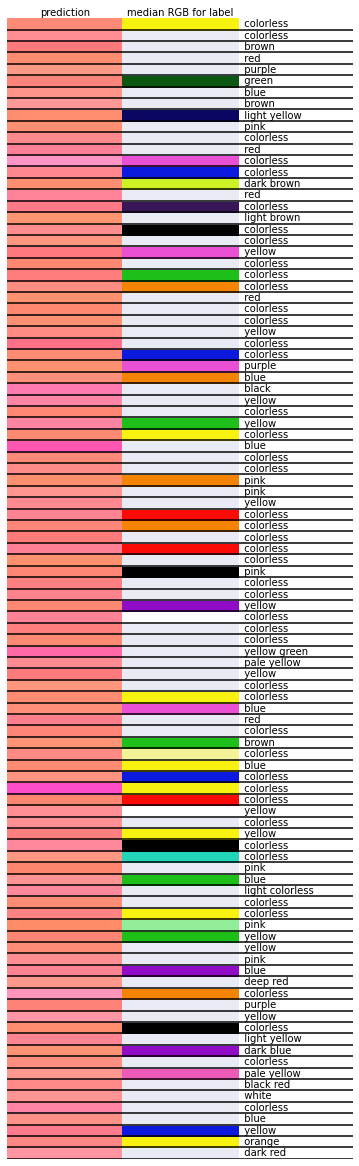

In [69]:
plot_predictions(y_predict  * 255, y_test * 255, name_test.values)